# TO DO

Do something better with the reading files. A common file structure or soemthing?

Here I'll make my fist attempt to open and look at my own data. using the tutorisl from [here](https://learn.astropy.org/tutorials/FITS-images.html)

## Version 2

- Now has a toggle for switching off plotting all the individual images. Can switch back on if you want to see the individual files.

- Now only divides by 16 for the actual 16000MM camera.

- File select now doesn't select any "mast_bias" if it exists, don't want to inlcude that if the bias_mast is run again.

In [1]:
import numpy as np

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from astropy.io import fits
from astropy.utils.data import download_file

import os
import glob
import time
from matplotlib.colors import LogNorm
from IPython import display
from IPython.display import clear_output

import random


plt.rcParams.update({'font.size':15})

In [2]:
plot_images = True
plot_images = False

In [68]:
file_object  = "tyc_3023-1974-1"

file_night  = "2023_04_02"
#file_night  = "2023_04_03"
#file_night  = "2023_04_19"

In [68]:
file_object = "RZ_Cas"
file_night  = "2023_03_02"
file_night  = "2023_04_06"
file_night  = "2023_10_14"
file_night  = "2023_11_30"

In [136]:
file_object = "RZ_Cep"
file_night  = "2022_12_07"
file_night  = "2023_01_23"
file_night  = "2023_02_23"
file_night  = "2023_11_10"
file_night  = "2024_01_07"
file_night  = "2024_01_18"

In [137]:
biasfilepath = "../../BPO_Data/"+file_object+"/"+file_night+"/Bias/"

main_star = file_object

Next want to grab all the file names in a sub-folder. I'm using glob to do it as it saves me typing in the file names by hand.

In [138]:
image_list = []
n = 0


for file in glob.glob(biasfilepath+"*Bias_*.fits*"):
    image_list.append(file)
    n=n+1
print("\n".join(image_list))

../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_001.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_002.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_003.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_004.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_005.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_006.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_007.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_008.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_009.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_010.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_011.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_012.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_013.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_014.fits
../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_015.fits
../../BPO_

In [139]:
image_concat = [fits.getdata(image) for image in image_list]

hdu_number = 0 # HDU means header data unit
image_hdr = [fits.getheader(image, hdu_number) for image in image_list]

In [140]:
N_images = np.shape(image_concat)
print(N_images) #shape of array, imagex X y-pixels X x-pixels
print(N_images[0]) #number of images

image_concat[0]

(26, 3520, 4656)
26


array([[176, 144, 128, ..., 160, 144,  96],
       [176, 144, 192, ..., 112, 176, 128],
       [128, 128, 176, ..., 128, 128,  96],
       ...,
       [112, 176, 112, ..., 144,  96, 144],
       [112, 144, 112, ...,  80, 112, 128],
       [112, 112, 144, ...,  64, 112, 128]], dtype=uint16)

The ZWo amera is 12 bit, but it scales the output to 16 bit, so a 2^4=16 difference. We need ot rmeove but only for the ASI1600MM Pro camera, our other main camera is an actual 16 bit camera.

In [141]:
if image_hdr[0]['INSTRUME'] == 'ZWO CCD ASI1600MM Pro':
    for i in range(N_images[0]):
        image_concat[i] = image_concat[i] /16
   

In [142]:
image_hdr[0]

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4656 / length of data axis 1                          
NAXIS2  =                 3520 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'ZWO CCD ASI1600MM Pro' / CCD Name                                    
TELESCOP= 'SynScan '        

Lets just check we now have a 3D arrany of data: photo number, y-pixels and x-pixels

Make various arrays of zeros so I can store various stat things about each of the images.

In [143]:
image_min = np.zeros(N_images[0])
image_max = np.zeros(N_images[0])
image_mean = np.zeros(N_images[0])
image_median = np.zeros(N_images[0])
image_stdev = np.zeros(N_images[0])

Now cycle through each image, plot, work out some stats of each image and a histrogram. This is the first chance to see if there are any dodgy images that once identified can be cut from the original directory if required. Maybe htere is a satelite, or a off flash or a UFO. 

To make the plots below look ok, we spread the gray scale from the mean $\pm$ some number of standard deviations. You can play with that number to make the plots more useful. Here I've stuck with a linear scale, but you can set to log if you wish.

In [144]:
N_std = 0.2


for i in range(N_images[0]):
    clear_output(wait=True)

    
    
    print(image_list[i])
    image_min[i] = np.min(image_concat[i])
    image_max[i] = np.max(image_concat[i])
    image_mean[i] = np.mean(image_concat[i])
    image_median[i] = np.median(image_concat[i])
    image_stdev[i] = np.std(image_concat[i])

    
    
    print('Min:', image_min[i] )
    print('Max:', image_max[i] )    
    print('Mean:', image_mean[i] )
    print('Median', image_median[i] )
    print('Stdev:', image_stdev[i] )


    if plot_images == True:
        
        plt.figure(figsize=(15,6))
    
        plt.subplot(1,2,1)
        plt.imshow(image_concat[i], cmap='gray', 
                   vmin= image_mean[i] - N_std*image_stdev[i], vmax=image_mean[i] + N_std*image_stdev[i]) 
        plt.title("Image "+ str(i))
        plt.colorbar()


        plt.subplot(1,2,2)
        plt.hist(image_concat[i].flatten(),bins=int(image_max[i]))
        plt.yscale('log')

        plt.show()

        time.sleep(1) #pause in secs. Make bigger if you need.


../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.000032_secs_026.fits
Min: 1.0
Max: 52.0
Mean: 7.243823097274289
Median 7.0
Stdev: 1.5869745498613232


Let's plot some of the stats we've just worked out

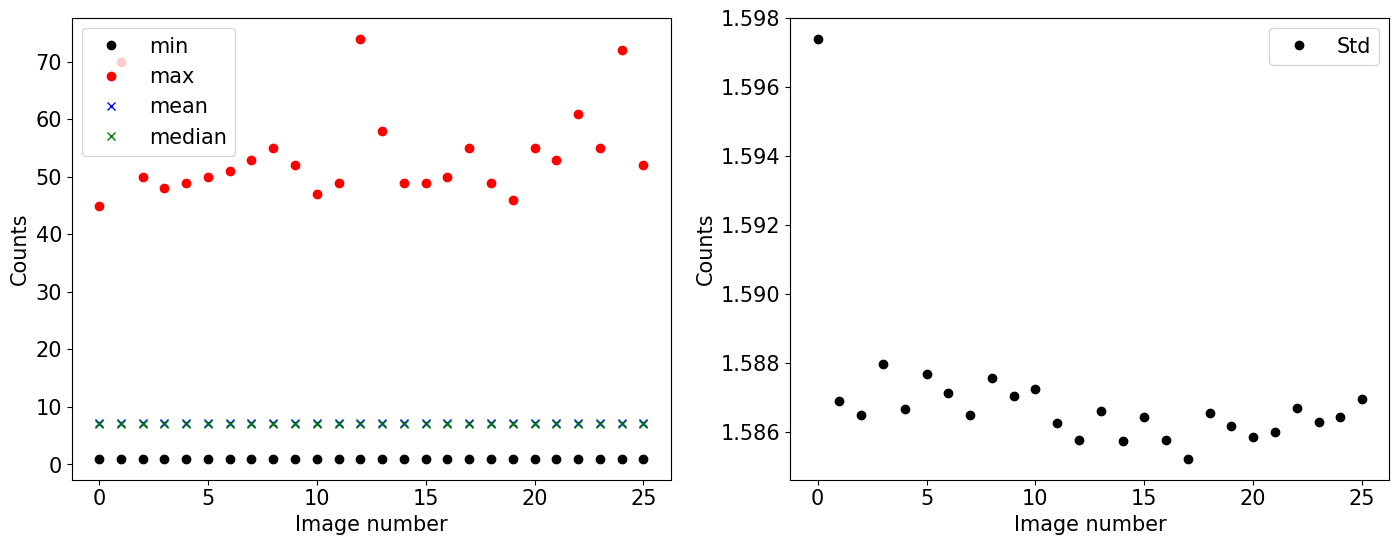

In [145]:
plt.figure(figsize=(17,6))

plt.subplot(1,2,1)
plt.plot(image_min,'ko',label='min')
plt.plot(image_max,'ro',label='max')
plt.plot(image_mean, 'bx', label='mean')
plt.plot(image_median,'gx',label='median')

plt.xlabel('Image number')
plt.ylabel('Counts')

plt.legend()


plt.subplot(1,2,2)
plt.plot(image_stdev,'ko',label='Std')

plt.xlabel('Image number')
plt.ylabel('Counts')

plt.legend()



plt.show()



Note, offentimes in the above image stats anaylysi the mean and hte median are nearly identical. And note that I think the np.ted returns the standard deviation of the inputs, not the standard deviation of the mean. Hence the second figure of the std will be $\pm$ something and not some tiny number.

Right now we can get onto the pixel by pixel analysis. Unlike the stuff above, which is per image, we care about per pixel. Given there are a few bias frames, it is as if we have measured the bias value of a pixel N times. So that's what we want to look at.

Let's do for 1 pixel first and build from there.

We'll also create a new array which is just a plain 3D array of integers so we can easily to maths across all images.

In [146]:
all_data = np.zeros(N_images)
for i in range(N_images[0]):
    all_data[i,:,:] = image_concat[i]

In [147]:
NyPix = np.shape(all_data)[1]
NxPix = np.shape(all_data)[2]
print(NxPix,NyPix)

4656 3520


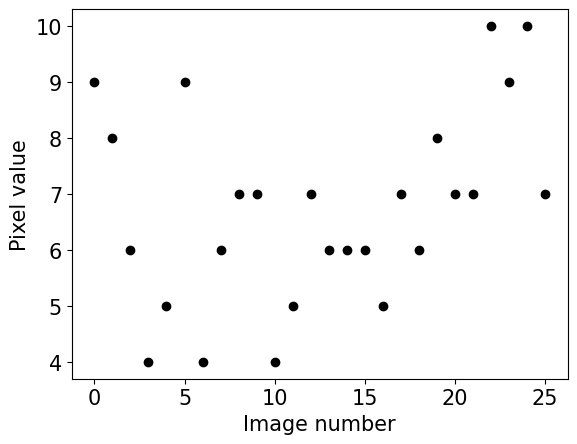

In [148]:
x = int(random.randint(1, NxPix))
y = int(random.randint(1, NyPix))

plt.plot(all_data[:,y,x],'ko' )

plt.xlabel('Image number')
plt.ylabel('Pixel value')

plt.show()

So there is some variation due to the inherent noise on the bias and the noise introduced by reading the image as well. Let's plot a few of these just to see what they look like. If I was being really good I'd randommly select some pixels, but I can't be bothered.

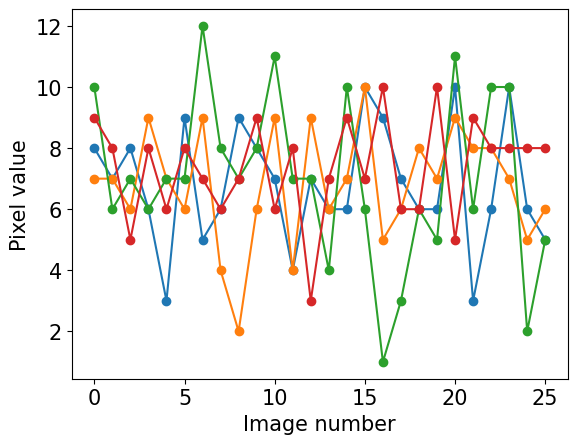

In [149]:
x_list = np.zeros(4)
y_list =  np.zeros(4)
x_list = [random.randint(1, NxPix),random.randint(1, NxPix),random.randint(1, NxPix),random.randint(1, NxPix)]
y_list = [random.randint(1, NyPix),random.randint(1, NyPix),random.randint(1, NyPix),random.randint(1, NyPix)]

for i in range(4):
    plt.plot(all_data[:,y_list[i],x_list[i]],'-o')



plt.xlabel('Image number')
plt.ylabel('Pixel value')

plt.show()

So we can see for these there is a similar distribution for each pixel. Now let's work out the standard deviation, since we have a nice 3D array this should be easy to do. Since our first dimension 0 is the image number that's what we want to compute over 

In [150]:
pixels_std = np.std(all_data, axis=0)

In [151]:
np.shape(pixels_std)

(3520, 4656)

So we now have a new array where each entry if the std of the bias over the N bias images pixel by pixel. Let's have a quick look at it as a histogram.

In [152]:

std_mean = np.mean(pixels_std)
std_std = np.std(pixels_std)

if plot_images == True:
    plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)
    plt.imshow(pixels_std, cmap='gray',
               vmin= std_mean - N_std*std_std, vmax=std_mean + N_std*std_std)
    plt.title("STD image")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.hist(pixels_std.flatten(),bins=100)
    plt.xlabel('standard deviation of a pixel')
    plt.ylabel('number of pixels')


    plt.show()


So I think we're in a position to compute the overall uncertainty on a raw bias value, the measn across all of the above values.

In [153]:
Uncertainty_bias_raw = np.median(pixels_std)
print(Uncertainty_bias_raw)

1.469613321118677


From the manual of the [camera](https://moodle.bath.ac.uk/pluginfile.php/2010269/mod_resource/content/1/ZWO_ASI1600_Manual_EN.pdf) we can see that at the gain we use of 139 then we can read off that the read-noise should be 1.7 counts. Nearly exactly what we've just found for the Uncertainty_bias_raw. So infact the actual uncertainty on the bias image is nearly all due to the read-noise, not the true bias value noise.

So let's say that the read noise is 



In [154]:
print('Read uncertainty: {0:.2f} counts'.format(Uncertainty_bias_raw))


Read uncertainty: 1.47 counts


And so we can conclude that the uncertainty on the bias value is, to 2 significant figures = 0.0

For fun let's make a master bias using the median of values pixel by pixel.

In [155]:
master_bias = np.mean(all_data, axis=0)

Min: 4.0
Max: 25.03846153846154
Mean: 7.239626549151565
Median 7.230769230769231
Stdev: 0.36659481867654925


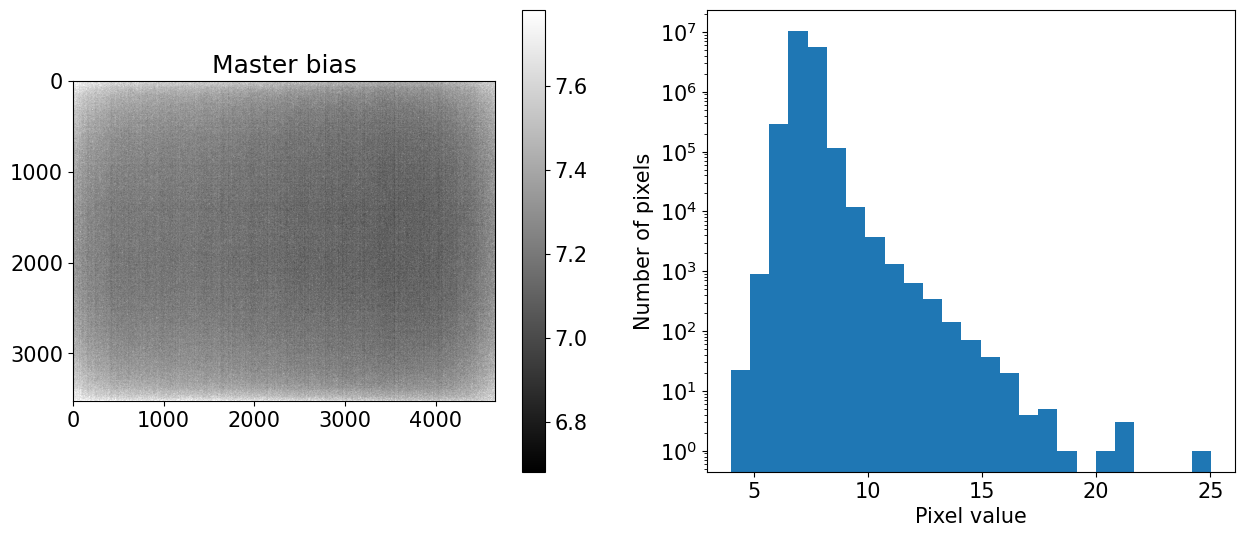

In [156]:
plt.figure(figsize=(15,6))
            
    
N_std = 1.5
    
print('Min:', np.min(master_bias) )
print('Max:', np.max(master_bias)  )    
print('Mean:', np.mean(master_bias)  )
print('Median', np.median(master_bias)  )
print('Stdev:', np.std(master_bias)  )


    
plt.subplot(1,2,1)
plt.imshow(master_bias, cmap='gray', 
               vmin= np.median(master_bias) - N_std*np.std(master_bias), vmax=np.median(master_bias) + N_std*np.std(master_bias)) 
plt.title('Master bias')
plt.colorbar()


plt.subplot(1,2,2)
plt.hist(master_bias.flatten(),bins= int(np.max(master_bias)))
plt.yscale('log')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
  
plt.show()
    


So we can see by companing with the individual plots above that the image is much smoother. Since the uncertainty on each pixel is now smaller by $\sqrt{N}$ with $N$ the number of images that go into the master bias

In [157]:
outfile = biasfilepath+'master_bias.fits'

hdu = fits.PrimaryHDU(master_bias)
hdu.writeto(outfile, overwrite=True)

Word of warning. What this simple anlaysis doesn't do is deal with hot pixels, nor cosmic rays. To do that we have to do sigma-clipping and that is beyond my simple python ability. So at this stage we should turn to ccdproc. But at least we now have some insight into, here, Bias frames and the noise associated with them.

Now to be super useful, lets save the interesting stats to a datafram and so to a .csv file, so we can do some proper stats on stuff.

In [158]:
stats_data = np.zeros([N_images[0]+2,5])
stats_data[0:N_images[0],0] = image_min
stats_data[0:N_images[0],1] = image_max
stats_data[0:N_images[0],2] = image_mean
stats_data[0:N_images[0],3] = image_median
stats_data[0:N_images[0],4] = image_stdev


# Add master stats at the end
stats_data[-1,0] = np.min(master_bias)
stats_data[-1,1] = np.max(master_bias)
stats_data[-1,2] = np.mean(master_bias)
stats_data[-1,3] = np.median(master_bias)
stats_data[-1,4] = np.std(master_bias)

# Add  stats image at the end
stats_data[-2,0] = np.min(pixels_std)
stats_data[-2,1] = np.max(pixels_std)
stats_data[-2,2] = np.mean(pixels_std)
stats_data[-2,3] = np.median(pixels_std)
stats_data[-2,4] = np.std(pixels_std)

df_stats = pd.DataFrame(data=stats_data,columns=['min','max','mean','median','std'])

In [159]:
image_list.append(biasfilepath+'std_image')
image_list.append(biasfilepath+'master_bias.fits')


In [160]:
df_stats['filename'] = image_list

In [161]:
camera_temp = []
exposure = []
camera_filter = []

FILTER  = 'Luminance'

for n in range(N_images[0]):
    camera_temp.append(image_hdr[n]["CCD-TEMP"])
    exposure.append(image_hdr[n]["EXPTIME "])
    camera_filter.append(image_hdr[n]["FILTER "])

# need to do something for the std and master images etc.

mean_temp = np.mean(camera_temp)
mean_exposure = np.mean(exposure)


camera_temp.append(mean_temp)
camera_temp.append(mean_temp)
exposure.append(mean_exposure)
exposure.append(mean_exposure)
camera_filter.append(image_hdr[n]["FILTER "])
camera_filter.append(image_hdr[n]["FILTER "])

df_stats['Temp'] = camera_temp
df_stats['Exposure/s'] = exposure
df_stats['Filter '] = camera_filter

In [162]:
what_list = []
for i in range(N_images[0]):
    what_list.append('bias')
    
what_list.append('Std_image')
what_list.append('master')



# Make column of "what"
df_stats['what'] = what_list

In [163]:
df_stats

,min,max,mean,median,std,filename,Temp,Exposure/s,Filter,what
0,1.000000,45.000000,7.250422,7.000000,1.597399,../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.0...,-15.500000,0.000032,Red,bias
1,1.000000,70.000000,7.231769,7.000000,1.586910,../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.0...,-20.000000,0.000032,Red,bias
2,1.000000,50.000000,7.234176,7.000000,1.586512,../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.0...,-20.000000,0.000032,Red,bias
3,1.000000,48.000000,7.231191,7.000000,1.587966,../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.0...,-20.000000,0.000032,Red,bias
4,1.000000,49.000000,7.234136,7.000000,1.586671,../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.0...,-20.000000,0.000032,Red,bias
5,1.000000,50.000000,7.231611,7.000000,1.587700,../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.0...,-20.000000,0.000032,Red,bias
6,1.000000,51.000000,7.233238,7.000000,1.587143,../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.0...,-20.000000,0.000032,Red,bias
7,1.000000,53.000000,7.227534,7.000000,1.586510,../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.0...,-20.000000,0.000032,Red,bias
8,1.000000,55.000000,7.234133,7.000000,1.587578,../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.0...,-20.000000,0.000032,Red,bias
9,1.000000,52.000000,7.233511,7.000000,1.587064,../../BPO_Data/RZ_Cep/2024_01_18/Bias\Bias_0.0...,-20.000000,0.000032,Red,bias


In [164]:
df_stats.to_csv(biasfilepath+'bias_stats.csv') #write to file.